In [1]:
import numpy as np

from utils.plot_utils import init_darkmode

init_darkmode()

## General framework for mappings, iterating mappings and visualize iteration results

A `map`, `function` or `rule` in general has a `state` defined by a set of `variables` $V$ and some properties defined by a set of `parameters` $P$. A parameter is an estimate of a given property of the system.

In [8]:
from typing import Callable
import warnings
import sys
import matplotlib.pyplot as plt

def logistic_map(P:list, V:list, validate_args=False) -> list:
    """The implementation of the map knows the compostion
    of both variables `V` and parameters `P`,
    and returns a similar composed output state V`.
    """

    if validate_args:
        drop_unnecessary('parameters', P, 1)
        drop_unnecessary('variables', V, 1)
        return

    x = V[0]
    r = P[0]

    x = r * x * (1 - x)
    return [x]

# Define the dynamics of the predator prey system
def pred_prey_map(P:list, V:list, validate_args=False) -> list:
    """The implementation of the map knows the compostion
    of both variables `V` and parameters `P`,
    and returns a similar composed output state V`.
    """

    if validate_args:
        drop_unnecessary('parameters', P, 5)
        drop_unnecessary('variables', V, 2)
        return
    
    # Parameter setup
    a = P[0]
    b = P[1]
    c = P[2]
    d = P[3]
    timestep = P[4]
    
    # Map the states into local variable names
    x = V[0]
    y = V[1]

    # evaluate the current differentials
    x += (x * (a - b * y)) * timestep
    y += (-y * (c - d * x)) * timestep

    return [x, y]


def drop_unnecessary(label, L, req_size_L):
    if len(L) > req_size_L:
        warnings.warn(f'Warning: dropping unnecessary {label}: {L[req_size_L:]}')
        L[:] = list(L[:req_size_L])

def iterate(map: Callable, Ps, Vs=None, n=0) -> list:

    assert isinstance(Ps, list), f'Ps must be of type list, but Ps = {Ps}'
    assert len(Ps)>0 and Ps[0], f'the list P must contain a list of parameters, but Ps = {Ps}'
    # assert len(P)>0 and P[0] is not None and isinstance(P[0], list), 'P is a list of a list of parameters and must be of type list[list]'
    # assert P[0][0], 'P is a list of a list of parameters and must contain a parameter'

    if not Vs:
        Vs=None
        n=0

    # make sure Ps=[[..]] and Vs=[[..]] or [None]
    Ps = [Ps] if not isinstance(Ps[0], list) else Ps
    Vs = [Vs] if not Vs or not isinstance(Vs[0], list) else Vs

    # print(f'Vs: {Vs}')
    # call map once to validate args Ps and Vs
    # any unneccessary parameters or variables are dropped
    map(Ps[0], Vs[0], validate_args=True)

    # print(f'Ps: {Ps}')
    # print(f'Vs: {Vs}')
    iterations = []
    for P in Ps:
        # print(f'P: {P}')
        for V0 in Vs:
            T = []
            # print(f'V0: {V0}')
            if V0:
                Vi = V0
                T.append(Vi)
                for i in range(n):
                    Vj = map(P, Vi)
                    T.append(Vj)
                    Vi = Vj
            iterations.append([P, T, n])
    return iterations


def plot_iterations(Is, ax=None, figsize=(16,4), labels=False):

    id_name = {0:'x', 1:'y', 2:'z'}

    if ax:
        result = ax
    else:
        result = None
        _, ax = plt.subplots(1, 1, figsize=figsize)
    
    for I in Is:
        Ps = I[0]
        Vs = I[1]
        n = I[2]
        
        V0 = [f'{v:.4g}' for v in Vs[0]]
        n_variables = len(V0)
        ylabels=[]
        for i in range(n_variables):
            Vi = [v[i] for v in Vs]
            ax.plot(Vi, marker='.', lw=1,label=f'${id_name[i]} \, | \, Ps={Ps}, \, V_0={V0}$')
            ylabels.append(f'${id_name[i]}_t$')
    ax.set_xlabel(f'$time$ $→$')
    ax.set_ylabel(' / '.join(ylabels))
    if n < 20:
        ax.set_xticks(range(0, n+1))

    plt.legend(loc="upper left")
    if result is None:
        plt.tight_layout()
    return result


def plot_cobweb(map, Is, P, ax=None):
    """
    A cobweb plot, or Verhulst diagram is a visual tool used in the dynamical systems 
    field of mathematics to investigate the qualitative behaviour of one-dimensional 
    iterated functions, such as the logistic map. 
    
    Using a cobweb plot, it is possible to infer the long term status of an initial 
    condition under repeated application of a map.
    """

    # check map is 1D, has one variable only
    # and get bounds of the maps variable
    v_min, v_max = (0.0, 1.0)
    for i, I in enumerate(Is):
        Pi = I[0]
        if Pi == P:
            Vs = I[1]
            for V in Vs:
                if V:
                    try:
                        if not len(V)==1:
                            raise ValueError(f"Map has {len(V)} variables, only 1 variable expected.")
                        else:
                            v = V[0]
                            if v:
                                v_min = min(v, v_min)
                                v_max = max(v, v_max)
                    except ValueError as exp:
                        print (f'Error (plot_cobweb):', exp)
                        sys.exit(exp)
    # print(f'v_min: {v_min}')
    # print(f'v_max: {v_max}')

    if not ax:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))

    # plot mapping
    x = np.linspace(v_min, v_max)
    y = map(P, [x])[0]
    ax.plot(x, y, c='b', lw=2)
    ax.plot(x, x, c='b', lw=1)

    for i, I in enumerate(Is):
        Pi = I[0]
        if Pi == P:
            Vs = I[1]
            n = I[2]
            V = [v[0] for v in Vs]
        
            # plot iteration
            if not V:
                r = P[0]
                ax.set_title(f'$r={r:.1f}$')
            else:
                if n==0:
                    ax.plot([V[0]], [V[0]], 'oy', ms=5)
                    # ax.set_title(f'$r={r:.1f}, \, x_0={t[0]:.2g}$')
                else:
                    # Recursively apply y=f(x) and plot two lines:
                    # (x, x) -> (x, y)
                    # (x, y) -> (y, y)
                    for i in range(n-1):
                        ax.plot([V[i], V[i]], [V[i], V[i+1]], c='y', lw=1)
                        ax.plot([V[i]], [V[i+1]], 'oy', ms=5, alpha=(i+1)/n)
                        ax.plot([V[i], V[i+1]], [V[i+1], V[i+1]], c='y', lw=1)
                    ax.plot([V[-2], V[-2]], [V[-2], V[-1]], c='y', lw=1)
                    ax.plot([V[0]], [V[0]], 'or', ms=5)
                    c = 'g' if n>1 else 'y'
                    ax.plot([V[-2]], [V[-1]], color=c, marker='o', ms=5)
                    # ax.set_title(f'$r={r:.6g}, \, x_0={t[0]:.2g}, \, n={n}$')
                    ax.set_ylabel('$x_{t+1}$')
            ax.set_xlabel('$x_{t}$')
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)

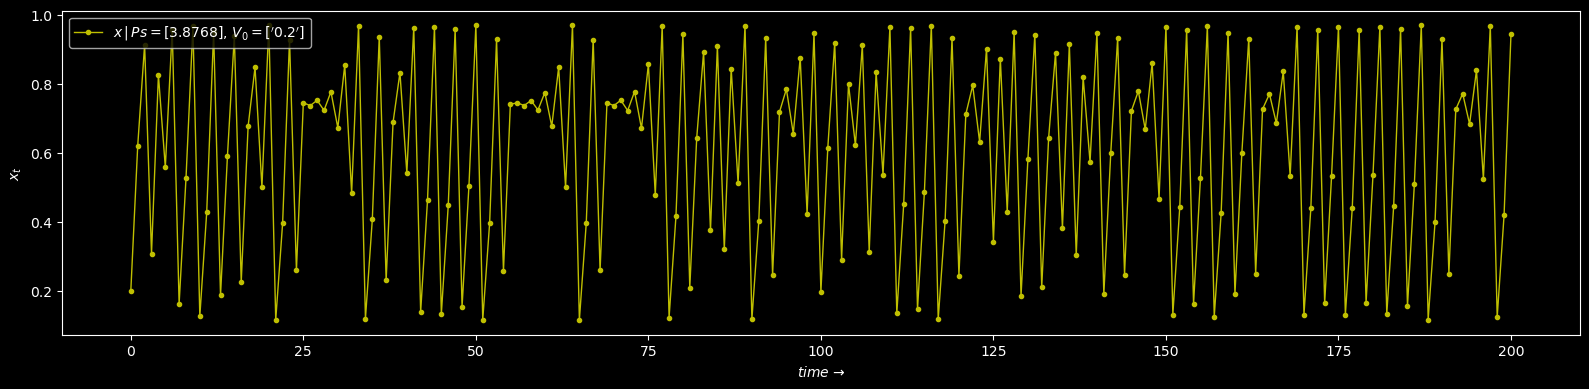

In [19]:
r = 3.8768
x0 = 0.2

P = [r]
V = [x0]

Is = iterate(logistic_map, Ps=[P], Vs=[V], n=200)

plot_iterations(Is)

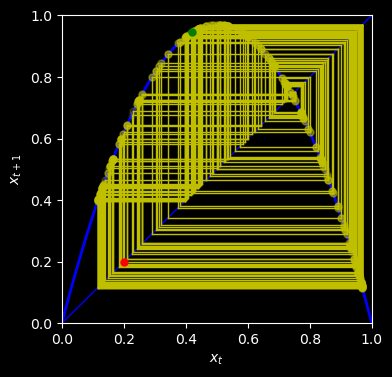

In [18]:
plot_cobweb(logistic_map, Is, P)

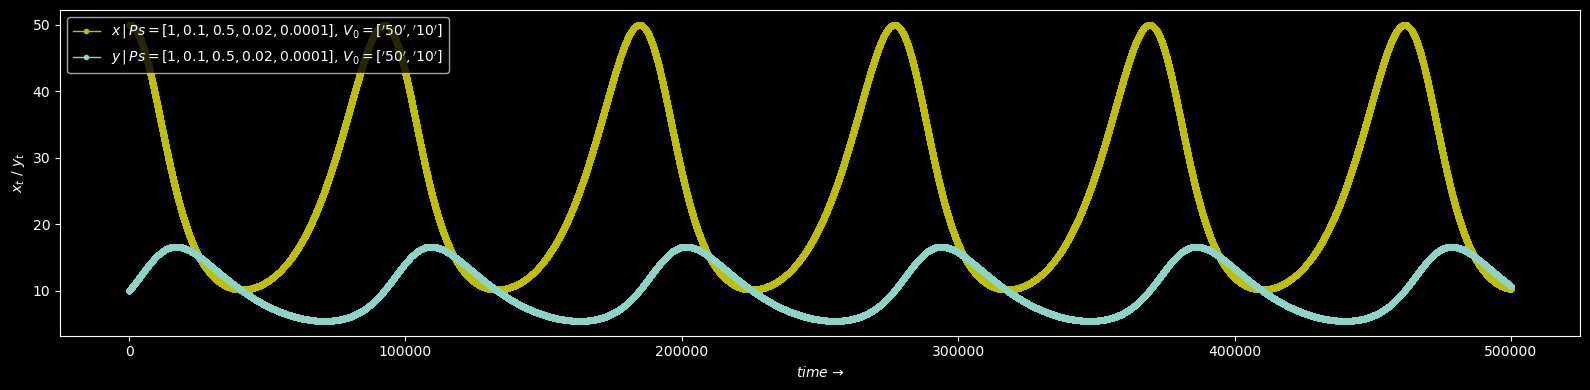

In [ ]:
# initial conditions for the rabbit (x) and fox (y)
x0 = 50 # rabbits
y0 = 10 # foxes
V = [[x0, y0]]

# definition of lotka-volterra parameters
a = 1     # birth rate of rabbits
b = 0.1   # death rate of rabbits due to predation
c = 0.5   # natural death rate of foxes
d = 0.02  # factor that describes how many eaten rabbits give birth to a new fox

timestep = 0.0001   #0.001
n = 50

P = [[a, b, c ,d, timestep]]

Is = iterate(pred_prey_map, P, V, n=int(n/timestep))

plot_iterations(Is)
